# Final Capstone Project Report - The Battle of Neighborhoods 

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


## 1. Introduction: Business Problem <a name="introduction"></a>

### Exploring the best venues in Dhaka, the Capital of Bangladesh. 

Dhaka, the capital of Bangladesh. More than 19.5 million people live in Dhaka. It is the most densely populated city in the country spanning 300 kilometers — about 186 miles. The rich traditions and the interesting history of Dhaka have managed to attract a lot of tourists over the years. And the number of tourists visiting the area has only increased with time. This city definitely stands on the expectations and pressure that comes with the capital city. Dhaka is much more than traditions and boring business numbers. 

When tourists visit a city or country it's apparent that they will look for the best places to stay and eat. They tend to visit places based on previous user ratings or prices. There are many venues in Dhaka for eating and staying, but not all of them are best, or not all of them are affordable for everyone.

The main goal of this project is to explore various venues in Dhaka and analyze them based on **user ratings and pricing tiers**. We'll focus specifically on the *'food'* and *'hotel/resort'* category. This project will use **FourSquare API** as its prime data gathering source as it has a database of millions of places, especially their places API which provides the ability to perform location search, location sharing, and details about a business. Further, a map of the venues with specific color attributes will be plotted to highlight the position and information about these venues. This enables tourists to choose the perfect venues to eat and stay.

### Target Audience:

The target audience for this project can be divided into two categories. First, tourists who are visiting Dhaka, Bangladesh can use the clustered map to decide what places to visit and in which hotel or resort to stay based on their budget and rating preferences. Second, developers can create a website or mobile application using this information, in which the data about location will be updated on a regular basis, to help tourists decide the places to visit and hotels to stay in.

## 2. Data <a name="data"></a>

### Data Scource

#### Foursquare API Data:

This project uses Foursquare API to get location data and other information about different venues in Dhaka, Bangladesh.

#### Data Cleaning:

Foursquare API returns many data for each venue. The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

  1. **Name:** The name of the venue
  3. **Rating:** The rating provided by the users
  4. **Price category:** The price category the venues belongs to as defined by the API
  6. **Latitude:** The latitude of the venue
  7. **Longitude:** The longitude of the venue
  8. **Category:** The category defined by the API
  9. **Address:** The address of the venue

### Dhaka

We can use the geocoder library to extract the latitude and longitude. Let's first find the latitude & longitude of Gulshan, Dhaka (choosed Gulshan as it's in the middle of Dhaka), using geocoder.

In [5]:
#!pip install geocoder
import geocoder

def get_latilong():
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('Gulshan, Dhaka, Bangladesh')
        lati_long_coords = g.latlng
    return lati_long_coords
    
dhaka_latlong = get_latilong()

print('Latitude of Dhaka: {}, Longitude of Dhaka: {}.'.format(dhaka_latlong[0], dhaka_latlong[1]))

Latitude of Dhaka: 23.782660000000078, Longitude of Dhaka: 90.41164000000003.


We'll a create map zoomed on Dhaka using **folium**. Let's also plot a marker on Gulshan, Dhaka, using the extracted coordinates. It'll help us visualize our starting point for the next phase, i.e data extraction from FourSquare API.

In [6]:
import folium

dhaka_map = folium.Map(location = dhaka_latlong, zoom_start = 12)
folium.Marker(dhaka_latlong).add_to(dhaka_map)

For using Foursquare API we'll need to **create a developer/sandbox account**. After creating the account we'll have to **create a project**. Once the project is created we'll be able to access the **client_id, client_secret** that will be necessary for fetching data from Foursquare API. We'll also have to set up an **access_token** that is required for some endpoints.

Next, we will set the **radius to 9 Kilometers**.
We'll also need a **version parameter in 'YYYYMMDD' format**. We can simply set it to the **current date** to retrieve the **latest data**.

In [38]:
# The code was removed by Watson Studio for sharing.

Let's define a function that extracts the category of the venue.

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now, Let's import the required libraries.

In [9]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

As per documentation the maximum venues the Foursquare API can fetch is 100. So we need to call the API multiple times until all the avaiable venues are fetched. We'll increase the offset by 100 in each iteration to get the next 100 venues if avaiable.

In [10]:
offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['VenueId', 'Name', 'Categories', 'Latitude', 'Longitude'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(CLIENT_ID, 
                                                                        CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        dhaka_latlong[0], 
                                                                        dhaka_latlong[1],
                                                                        RADIUS,
                                                                        LIMIT,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.id', 'venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = ['VenueId', 'Name', 'Categories', 'Latitude', 'Longitude']
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 100 venues fetched within a total radius of 9.0 Km


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


Total 54 venues fetched within a total radius of 9.0 Km

Total 154 venues fetched


Let's have a look at the dataset.

In [11]:
foursquare_venues.head(10)

,VenueId,Name,Categories,Latitude,Longitude
0,4be12ee6c1732d7f786c5b9a,Movenpick,Ice Cream Shop,23.792333,90.415373
1,4c5814257329c92817379080,Izumi,Sushi Restaurant,23.788599,90.420536
2,519ce62a498e4edb08ffc5ba,"Kiva Han, Gulshan 1",Café,23.781923,90.415860
3,4dc528f9e4cd169dc644a25f,North End Coffee Roasters,Café,23.793628,90.424364
4,574c40bc498eaa071c56ecd7,North End Coffee Roasters,Café,23.782054,90.416337
5,5670eeda498efccf880ad543,North End Coffee Roasters @ Cityscape Tower,Coffee Shop,23.785826,90.416986
6,516eb51be4b0500ec38787b2,Astorion,Clothing Store,23.788444,90.414271
7,51debf4d498e2375fdff6d9b,unimart,Supermarket,23.795924,90.415092
8,4b9b3162f964a5200cf935e3,BRAC Center,Office,23.780193,90.410185
9,4c1ad5a3b306c928f65761b7,Taste,Café,23.793325,90.414650


Let's define a function to that will allow us to retrive only the venues that we're interested in.

In [12]:
def get_venues_of_interest(categories):
    words = ['restaurant', 'diner', 'taverna', 'steakhouse', 'food','burger','ice cream', 'fish', 'chicken','hotel','resort', 'pizza','supermarket', 'café', 'coffee', 'bar','bbq']
    interested = False
    category_name = categories.lower()
    for w in words:
        if w in category_name:
            interested = True
    return interested

Now, let's retrive the venues that we're interested in.

In [13]:
updated_venues = foursquare_venues[foursquare_venues['Categories'].apply(get_venues_of_interest)].reset_index(drop = True)
updated_venues.shape

(98, 5)

The *'/explore'* endpoint of Foursquare API doesn't return some required venue properties like **price, rating, address, etc**. So we've retrieved more details about each venue from Foursquare by the **venue_id** that we've retrieved earlier. 

In [14]:
venues_information = []

for index, row in updated_venues.iterrows():
    venue = []
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&oauth_token={}&v={}'.format(row['VenueId'], CLIENT_ID, CLIENT_SECRET,ACCESS_TOKEN, VERSION)

    try:
        result = requests.get(url).json()
    except:
        print("Some error occured...")
    try:
        venue.append(result['response']['venue']['price']['tier'])
        venue.append(result['response']['venue']['rating'])
        venue.append(result['response']['venue']['location']['address'])
        venues_information.append(venue)
    except:
        pass
        
venues_details = pd.DataFrame(venues_information, 
                                  columns = ['PricingTier', 'Rating', 
                                             'Address'])

As FourSquare venue '/details' API endpoint rate limit is only 50 per day for sandbox accounts, so we had to run this multiple times and we stored the data into an excel file. 

Let's retrieve the venue details dataset from the excel file.

In [15]:
venues_details = pd.read_excel('venues_details.xlsx')
venues_details.shape

(98, 3)

### Data Preparation

Now we have **two different datasets**, retrieved from API separately.

Let's combine both datasets.

In [16]:
df = pd.concat([updated_venues, venues_details], axis = 1, sort = False)
df.head()

,VenueId,Name,Categories,Latitude,Longitude,PricingTier,Rating,Address
0,4be12ee6c1732d7f786c5b9a,Movenpick,Ice Cream Shop,23.792333,90.415373,1.0,8.7,"Gulshan, Dhaka"
1,4c5814257329c92817379080,Izumi,Sushi Restaurant,23.788599,90.420536,2.0,8.6,"Gulshan, Dhaka"
2,519ce62a498e4edb08ffc5ba,"Kiva Han, Gulshan 1",Café,23.781923,90.415860,1.0,8.1,"Gulshan, Dhaka"
3,4dc528f9e4cd169dc644a25f,North End Coffee Roasters,Café,23.793628,90.424364,1.0,8.6,Dhaka
4,574c40bc498eaa071c56ecd7,North End Coffee Roasters,Café,23.782054,90.416337,1.0,8.1,"Gulshan, Gulshan 2"


We've some rows with missing **PricingTier and Rating** values, let's drop them.

In [17]:
dataset = df.dropna().reset_index(drop=True)
print("Total number of venues available: {}".format(dataset.shape[0]))

Total number of venues available: 85


Now that our dataset is ready, let's plot all the venues in the dataset on the map.

In [18]:
dhaka_venues_map = folium.Map(location = dhaka_latlong, zoom_start = 12)

for name, latitude, longitude in zip(dataset['Name'], dataset['Latitude'], dataset['Longitude']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(dhaka_venues_map)  

#dhaka_venues_map

## 3. Methodology <a name="methodology"></a>

The main goal of this project is to explore various venues in Dhaka based on user rating and average price. It aims at allowing visitors to identify the best places to eat and stay around the city. We will extract data within an area of **9km** around the city center, as it covers most of the places of the City.

In the first step, we have retrieved the venues from **Foursquare** within 9km from Gulshan, Dhaka. But the initial data doesn't contain venue details like **price, rating, etc**. So we've retrieved more details about each venue from Foursquare by the **venue_id** that we've retrieved earlier. 

In the second step, we've **combined the detailed dataset** with the previously retrieved data. Then we've **cleaned the data** by dropping the rows with missing prices or ratings. So the final dataset contains all the required features about each venue including price and rating.

In the final step, we'll analyze the data that we created based on the ratings and price of each venue. We will use **heatmaps** to identify areas where the venues are located. This will allow visitors to choose the areas with **a large number of venues**, this way they will have more options to choose from in one go. We'll explore venues based on pricing tier and rating. We'll identify the **number of venues per category using a barplot**. We'll identify which categories of venues are popular in the city. We will present the results of the analysis in the form of **plots, maps** to the stakeholders so that it'll be easy to understand for them. The venues **will be clustered based on the extracted information** we've for each venue. We'll analyze the areas that belong to each cluster. This way we'll be able to identify the areas that are most suitable for a particular visitor based on their **pricing and rating preferences**.

## 4. Analysis <a name="analysis"></a>

Now we will perform some basic explanatory data analysis to get more insights from our raw data.

Let's use a heatmap to see in which areas of the city the venues are located.

In [19]:
import json # library to handle JSON files

with open('dhaka.json') as json_data:
    dhaka_geojson = json.load(json_data)

def area_style(feature):
    return { 'color': 'blue', 'fill': False }

In [20]:
venues_latlons = []
for index, row in dataset.iterrows():
    venues_latlons.append([row['Latitude'],row['Longitude']])

In [21]:
from folium import plugins
from folium.plugins import HeatMap

map_dhaka = folium.Map(location=dhaka_latlong, zoom_start=12)
folium.TileLayer('cartodbpositron').add_to(map_dhaka) #cartodbpositron cartodbdark_matter
HeatMap(venues_latlons).add_to(map_dhaka)
folium.Marker(dhaka_latlong).add_to(map_dhaka)
folium.Circle(dhaka_latlong, radius=1000, fill=False, color='white').add_to(map_dhaka)
folium.Circle(dhaka_latlong, radius=2000, fill=False, color='white').add_to(map_dhaka)
folium.Circle(dhaka_latlong, radius=3000, fill=False, color='white').add_to(map_dhaka)
folium.GeoJson(dhaka_geojson, style_function=area_style, name='geojson').add_to(map_dhaka)
#map_dhaka

Most of the venues are located around the **Dhanmondi** and **Gulshan** area. So, these areas will be pretty much a good choice for visitors.

### Categories

Let's do some analysis based on the category of each venue. We'll use a barplot to visualize the number of venues for each category.

In [22]:
import seaborn as sns

Text(0, 0.5, 'Number of Venues')

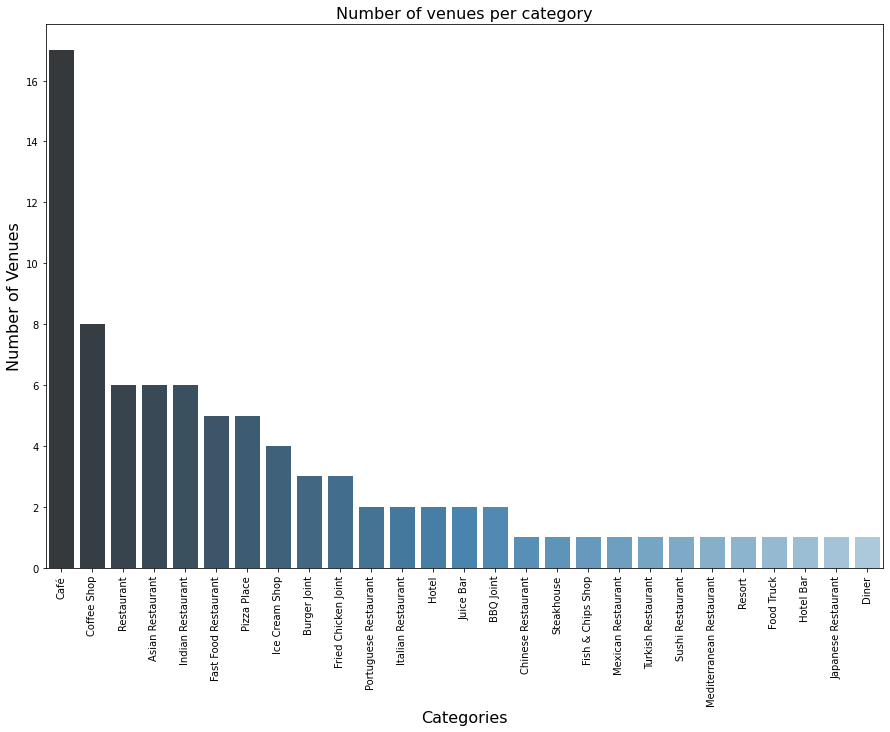

In [23]:
category_count = dataset['Categories'].value_counts()
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(category_count.index, category_count.values, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title("Number of venues per category",fontsize=16)
ax.set_xlabel("Categories",fontsize=16)
ax.set_ylabel("Number of Venues",fontsize=16)

Among the venues in our dataset, most of them are cafes, and a bit lower number of Coffee shops, Restaurants. So, visitors with interest in Cafe will have more options to choose from.

### Rating

Rating plays an important role in determining if a venue is worth visiting. Also, tourists tend to be more interested in previous user ratings for a venue, to decide if they should visit that venue or not.

The range of rating in our dataset is 1-10, Let's divide them into 4 bins and assign labels to the bins. Then show the number of venues in each category using a barplot.

In [24]:
bins = [2.0, 4.0, 6.0, 8.0, 10.0]
labels = ['Low', 'Okay', 'Good', 'Excellent']
dataset['RatingCategories'] = pd.cut(dataset['Rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Text(0, 0.5, 'Number of Venues')

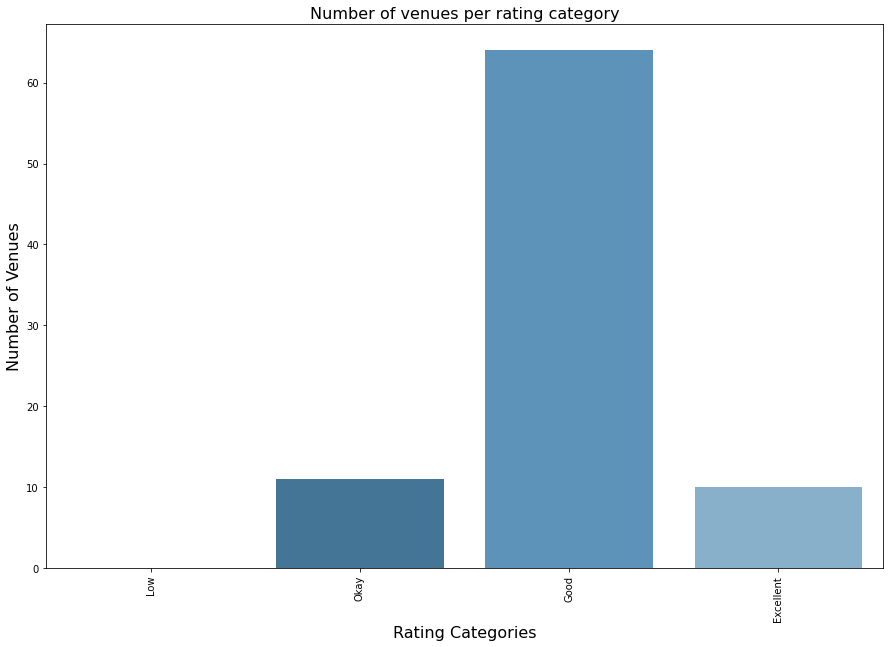

In [25]:
rating_count = dataset['RatingCategories'].value_counts()
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(rating_count.index, rating_count.values, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title("Number of venues per rating category",fontsize=16)
ax.set_xlabel("Rating Categories",fontsize=16)
ax.set_ylabel("Number of Venues",fontsize=16)

Let's see what venue categories are highly rated in the city using a boxplot.

Text(0, 0.5, 'Rating')

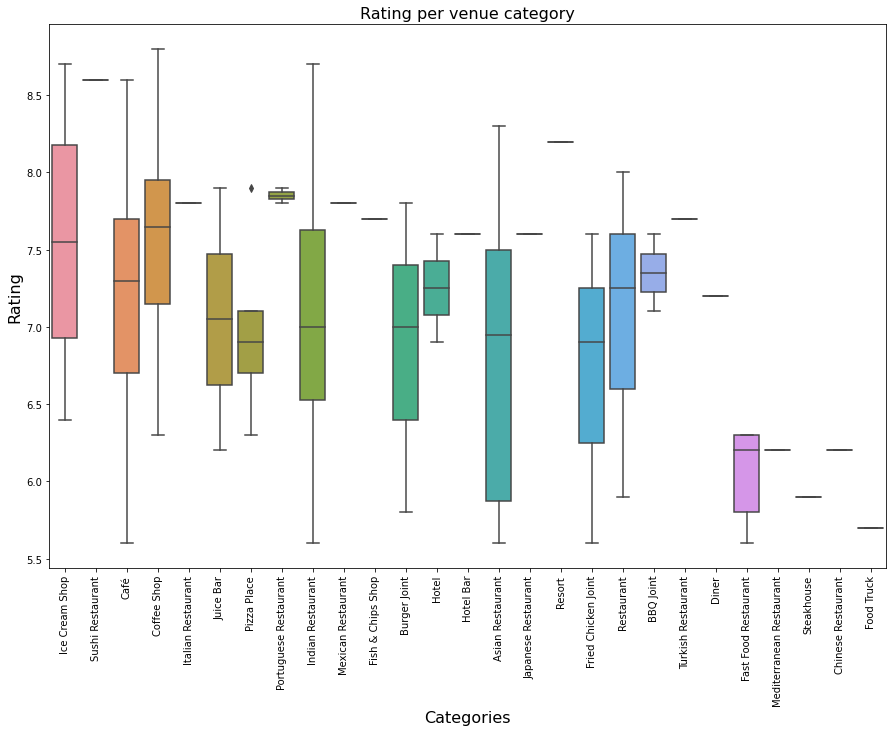

In [26]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = ax = sns.boxplot(x="Categories", y="Rating", data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title("Rating per venue category",fontsize=16)
ax.set_xlabel("Categories",fontsize=16)
ax.set_ylabel("Rating",fontsize=16)

The plot shows the **Ice Cream Shop** and **Cafe** categories are highly rated.

Let's plot the rating categories on the map, and see which areas have the highest rated venues.

In [27]:
color_map = {'Low': 'red', 'Okay': 'lightred', 'Good': 'orange', 'Excellent': 'green'}

rating_map = folium.Map(location = dhaka_latlong, zoom_start = 12)

for name, address, latitude, longitude, rating_cat in zip(dataset['Name'], 
                                                          dataset['Address'], 
                                                          dataset['Latitude'], 
                                                          dataset['Longitude'], 
                                                          dataset['RatingCategories']):
    label = '{}, {} - ({})'.format(name, address, rating_cat)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_cat]),
        popup = label).add_to(rating_map)  

#rating_map

### Price

There are many venues in Dhaka for eating and staying, but every person has their own budget or not all the venues are affordable to everyone. Let's how many venues fall under each pricing tier using a barplot.

There are four pricing tiers defined by the Foursquare API, 1 being the cheapest, and 4 being the most costly.

Text(0, 0.5, 'Number of Venues')

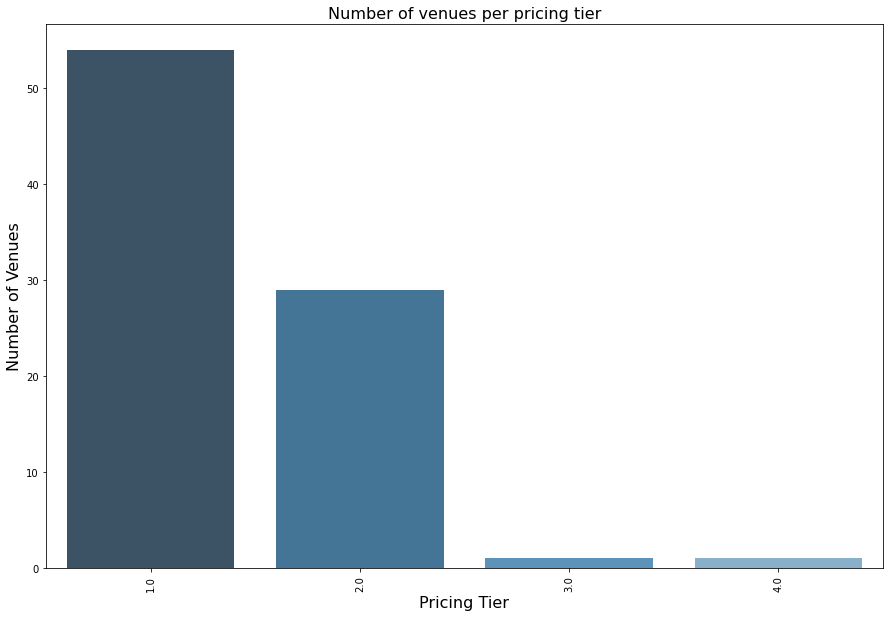

In [28]:
price_tier_count = dataset['PricingTier'].value_counts()
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.barplot(price_tier_count.index, price_tier_count.values, palette="Blues_d")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.axes.set_title("Number of venues per pricing tier",fontsize=16)
ax.set_xlabel("Pricing Tier",fontsize=16)
ax.set_ylabel("Number of Venues",fontsize=16)

It's good to see that most of the venues are in the cheapest pricing tier.

Let's plot the pricing tiers on the map to visualize pricing tiers in different areas.

In [29]:
color_map = {'1.0': 'green', '2.0': 'orange', '3.0': 'lightred', '4.0': 'red'}

price_visualization_map = folium.Map(location = dhaka_latlong, zoom_start = 12)

for name, address, latitude, longitude, price_tier in zip(dataset['Name'], 
                                                           dataset['Address'], 
                                                           dataset['Latitude'], 
                                                           dataset['Longitude'], 
                                                           dataset['PricingTier'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_tier]),
        popup = label).add_to(price_visualization_map)  

#price_visualization_map

### Clustering

Let's cluster the venues based on their price, rating, and location to get more insights about the venues and identify the relationship between them.

First, we'll drop the columns that we won't use for clustering. Then, we'll use **the Elbow Method** to determine the optimal number of clusters.

In [30]:
clustering_dataset = dataset.drop(['VenueId', 'Name', 'Categories', 'Address', 'RatingCategories'], axis=1)

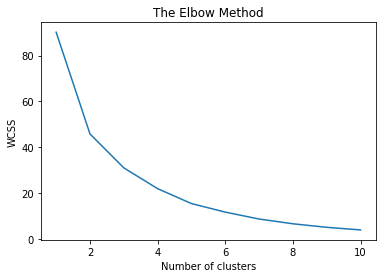

In [31]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(clustering_dataset)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

The steps of the elbow seem pretty smooth. Let's go with **2 clusters**.

In [32]:
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42).fit(clustering_dataset)
dataset.insert(0, 'Cluster Labels', kmeans.labels_)
dataset.head(5)

,Cluster Labels,VenueId,Name,Categories,Latitude,Longitude,PricingTier,Rating,Address,RatingCategories
0,0,4be12ee6c1732d7f786c5b9a,Movenpick,Ice Cream Shop,23.792333,90.415373,1.0,8.7,"Gulshan, Dhaka",Excellent
1,0,4c5814257329c92817379080,Izumi,Sushi Restaurant,23.788599,90.420536,2.0,8.6,"Gulshan, Dhaka",Excellent
2,0,519ce62a498e4edb08ffc5ba,"Kiva Han, Gulshan 1",Café,23.781923,90.415860,1.0,8.1,"Gulshan, Dhaka",Excellent
3,0,4dc528f9e4cd169dc644a25f,North End Coffee Roasters,Café,23.793628,90.424364,1.0,8.6,Dhaka,Excellent
4,0,574c40bc498eaa071c56ecd7,North End Coffee Roasters,Café,23.782054,90.416337,1.0,8.1,"Gulshan, Gulshan 2",Excellent


Now we'll plot the clusters on the map to get a better understanding.

In [33]:
cluster_map = folium.Map(location = dhaka_latlong, zoom_start = 12)
color_map = { 0: 'blue', 1: 'red'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(dataset['Name'], 
                                                        dataset['Address'], 
                                                        dataset['Cluster Labels'], 
                                                        dataset['Latitude'], 
                                                        dataset['Longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(cluster_map)

# add cluster centers to the map
for index, cluster in enumerate(kmeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(cluster_map)

#cluster_map

### Examine Clusters

Let's examine each of the clusters.

#### Cluster 1

In [34]:
result = dataset[dataset['Cluster Labels'] == 0]
result.head().reset_index(drop = True)

,Cluster Labels,VenueId,Name,Categories,Latitude,Longitude,PricingTier,Rating,Address,RatingCategories
0,0,4be12ee6c1732d7f786c5b9a,Movenpick,Ice Cream Shop,23.792333,90.415373,1.0,8.7,"Gulshan, Dhaka",Excellent
1,0,4c5814257329c92817379080,Izumi,Sushi Restaurant,23.788599,90.420536,2.0,8.6,"Gulshan, Dhaka",Excellent
2,0,519ce62a498e4edb08ffc5ba,"Kiva Han, Gulshan 1",Café,23.781923,90.415860,1.0,8.1,"Gulshan, Dhaka",Excellent
3,0,4dc528f9e4cd169dc644a25f,North End Coffee Roasters,Café,23.793628,90.424364,1.0,8.6,Dhaka,Excellent
4,0,574c40bc498eaa071c56ecd7,North End Coffee Roasters,Café,23.782054,90.416337,1.0,8.1,"Gulshan, Gulshan 2",Excellent


In [35]:
print("Average pricing tier of Cluster 1: {:.02f} \nAverage rating of Cluster 1: {:.02f}".
      format(result['PricingTier'].mean(), result['Rating'].astype(float).mean()))

Average pricing tier of Cluster 1: 1.40 
Average rating of Cluster 1: 7.71


#### Cluster 1

In [36]:
result = dataset[dataset['Cluster Labels'] == 1]
result.head().reset_index(drop = True)

,Cluster Labels,VenueId,Name,Categories,Latitude,Longitude,PricingTier,Rating,Address,RatingCategories
0,1,4dba722d4b22153e34b30ec4,Santoor,Indian Restaurant,23.751812,90.377602,2.0,6.9,"Dhanmondi, Dhaka",Good
1,1,4f842dd5e4b02ab94544f4e2,FARS Hotel & Resorts,Hotel,23.731652,90.410035,1.0,6.9,"Dhanmondi, Dhaka",Good
2,1,51237758e4b0dd57c25b958a,Pizza King,Pizza Place,23.719945,90.388840,1.0,6.7,"Mohammadpur, Dhaka",Good
3,1,4fe43d88e4b0a94749f4f07d,Seventh Heaven,Café,23.758298,90.374111,2.0,6.7,"Mohammadpur, Dhaka",Good
4,1,4ccd9a6397d0224ba32867b8,"BFC, Uttara",Fried Chicken Joint,23.861098,90.400060,1.0,6.9,"Pallabi, Dhaka",Good


In [37]:
print("Average pricing tier of Cluster 2: {:.02f} \nAverage rating of Cluster 2: {:.02f}".
      format(result['PricingTier'].mean(), result['Rating'].astype(float).mean()))

Average pricing tier of Cluster 2: 1.39 
Average rating of Cluster 2: 6.23


## 5. Results and Discussion <a name="results"></a>

From our analysis, we can come up with several conclusions that will enable tourists to choose the perfect venues to eat and stay in Dhaka, Bangladesh. We have extracted data within an area of 9km around the center of Dhaka. Initially, a total of 154 venues were fetched containing the categories of venues. As our analysis was focused mainly on the food and hotel/resort category, we removed other categories. The total number of venues were 98 after removing other categories. For these 98 venues, we fetched additional data: price_tier, rating, address. Then we combined the two datasets and dropped the rows containing the missing price or rating. Finally, we are had a total number of 85 venues available.

From the visualization of the venues of our interest, we see that most of the venues are located around the **Dhanmondi** and **Gulshan area**. So, these areas will be pretty much a good choice for visitors. Among the venues in our dataset, most of them are cafes, and a bit lower number of Coffee shops, Restaurants. So, visitors with interest in Cafe will have more options to choose from.

The range of rating in our dataset is 1-10, We've divided them into 4 bins with labels Low, Okay, Good, Excellent. We've identified that most of the venues are rated good. The map shows that these venues are around Dhanmondi and Gulshan areas. We've identified that the Ice Cream Shop and Cafe categories are highly rated. So we can say that these categories are most popular around the city. The analysis also shows that most of the venues are in the cheapest pricing tier. 

Using clustering we've separated the venues into two clusters. The average pricing tier of Cluster 1 shows 1.40 which is cheaper and the average rating of Cluster 1 shows 7.71 which is good. Cluster one contains most of the venues from Gulshan and a few from Dhanmodi. And the average pricing tier of Cluster 2 shows 1.39 which is cheaper and the average rating of Cluster 2 shows 6.23 which lower than cluster 1. Cluster two contains most of the venues from Dhanmondi. So if a tourist is looking for highly rated and cheaper venues then he/she can choose Gulshan. Otherwise, Dhanmondi is also a decent choice.
Apart from helping tourists, developers can create a website or mobile application using this information, to help tourists decide the places to visit and hotels to stay in.

## 6. Conclusion <a name="conclusion"></a>

The main goal of this project was to explore and identify popular venues in Dhaka city for tourists based on the user ratings and prices of venues. This project fetched data from the Foursquare API and analyzed the data to get insights. Then the results were visualized using different plots for a better understanding. Finally, a clustering step has been carried out and plotted the resultant clusters on the map. The map shows that there are two main areas tourists can visit: Dhanmondi and Gulshan. Although the Dhanmondi area contains some venues from cluster 1 also. The price ranges of both venues are almost the same, but the rating is a bit higher in the Gulshan area. Other than that both areas are great choices for tourists.